In [1]:
#Importing all the necessary libraries
from flask import Flask, render_template, request
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
#Defining the parameters
stock = 'BHARTIARTL.NS' #stock symbol
end = datetime.now()
start = datetime(end.year-20,end.month,end.day)

#Fetch Stock Data
stock_data = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4942 entries, 2004-05-07 to 2024-05-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4942 non-null   float64
 1   High       4942 non-null   float64
 2   Low        4942 non-null   float64
 3   Close      4942 non-null   float64
 4   Adj Close  4942 non-null   float64
 5   Volume     4942 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 270.3 KB


In [4]:
stock_data.describe()

Open         High          Low        Close    Adj Close  \
count  4942.000000  4942.000000  4942.000000  4942.000000  4942.000000   
mean    384.233593   389.831524   377.937152   383.829303   371.227856   
std     210.648847   212.552170   208.934857   210.771235   213.673004   
min      57.432617    59.392853    51.371662    56.846802    52.985020   
25%     282.183655   287.106758   277.057747   282.228699   267.830109   
50%     328.958893   334.096069   322.646255   328.988739   314.123337   
75%     413.535858   423.725784   404.614090   412.370270   388.672218   
max    1352.000000  1354.000000  1333.550049  1342.349976  1342.349976   

             Volume  
count  4.942000e+03  
mean   7.296282e+06  
std    8.640661e+06  
min    0.000000e+00  
25%    3.216739e+06  
50%    5.125742e+06  
75%    8.391964e+06  
max    1.985470e+08

In [5]:
stock_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Text(0.5, 1.0, 'Closing price of Stock data')

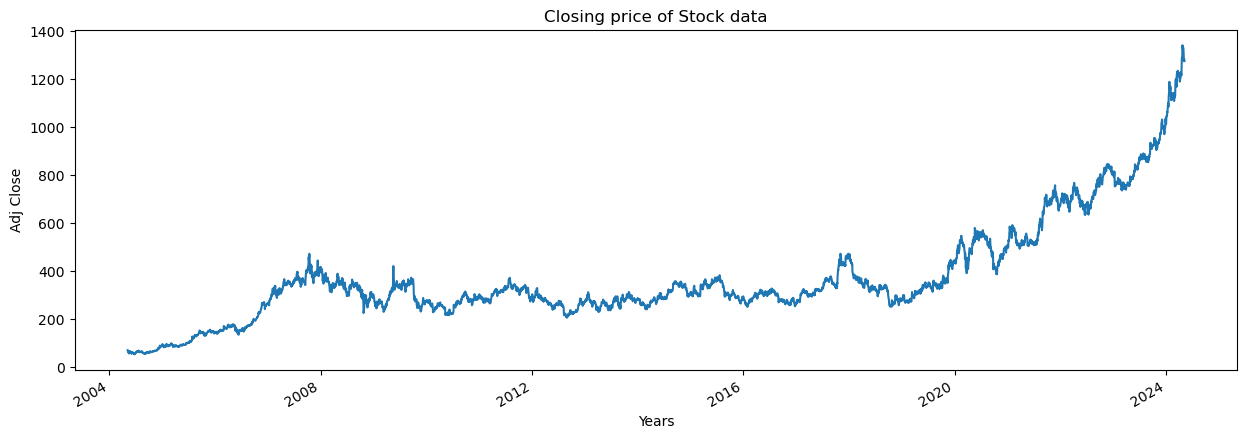

In [6]:
plt.figure(figsize = (15,5))
stock_data['Adj Close'].plot()
plt.xlabel("Years")
plt.ylabel("Adj Close")
plt.title("Closing price of Stock data")

In [7]:
def plot_graph(figsize, values, column_name):
    plt.figure()
    values.plot(figsize=figsize)
    plt.xlabel("Years")
    plt.ylabel(column_name)
    plt.title(f"{column_name} of Stock Data")

In [8]:
stock_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

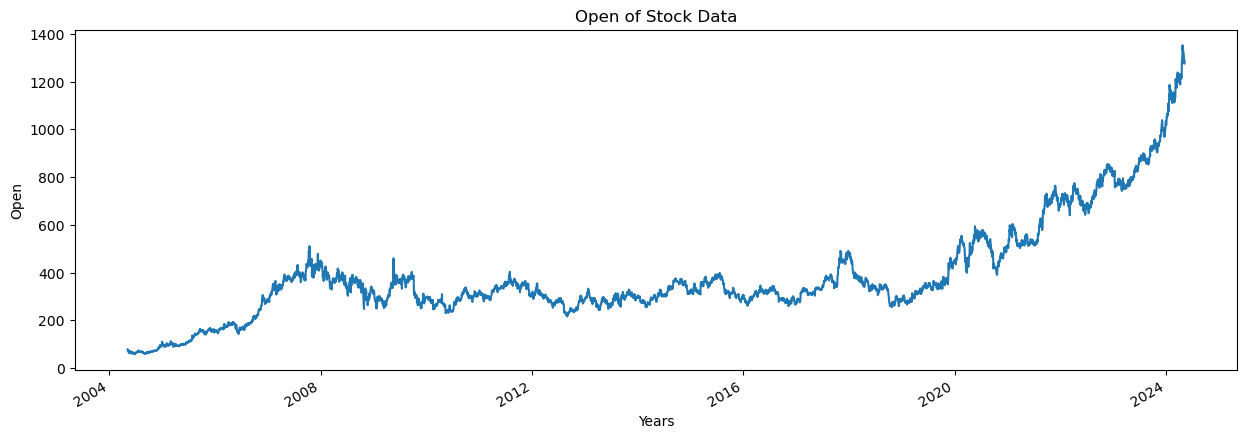

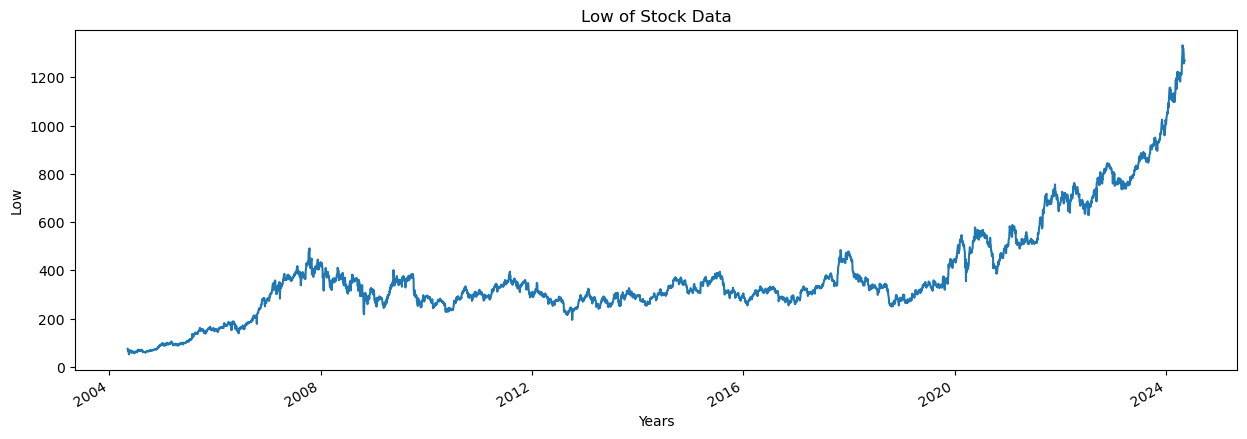

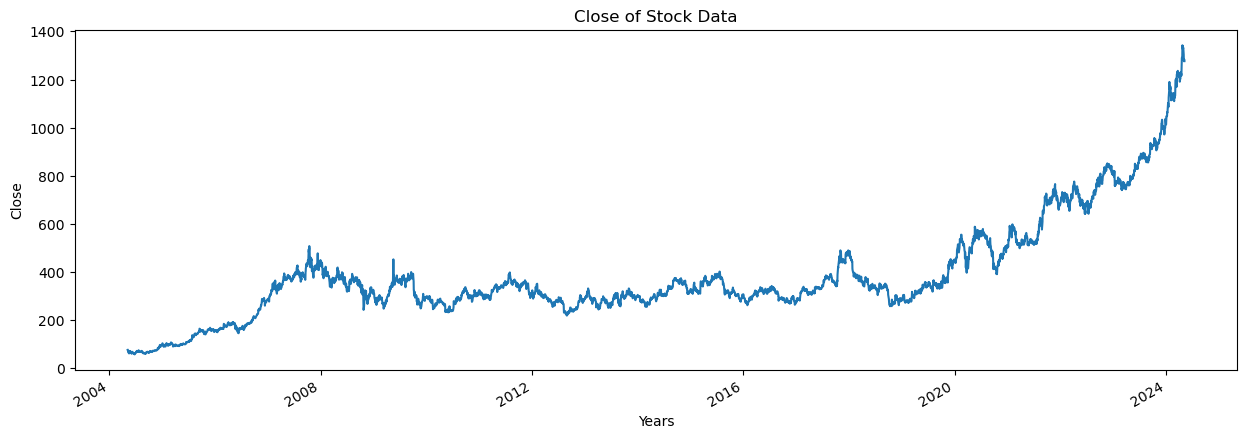

In [9]:
for column in stock_data.columns:
    plot_graph((15,5), stock_data[column], column)

In [10]:
#10, 20, 30, 40, 50, 60, 70, 80, 90, 100

# MA for 5 days ==> null null null null 30 40 50 60 70 80

temp_data = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
print(sum(temp_data[1:6])/5)

40.0


In [11]:
data= pd.DataFrame([10,20,30,40,50,60,70,80,90,100])
data.head()

0
0  10
1  20
2  30
3  40
4  50

In [12]:
# data['MA'] = data.rolling(5).mean()


In [13]:
for i in range(2020,2025):
    print(i, list(stock_data.index.year).count(i))

2020 251
2021 248
2022 248
2023 245
2024 84


In [14]:
stock_data['MA_for_250_days'] = stock_data['Adj Close'].rolling(250).mean()

In [15]:
stock_data['MA_for_250_days'][0:250].tail()

Date
2005-04-22          NaN
2005-04-25          NaN
2005-04-26          NaN
2005-04-27          NaN
2005-04-28    73.146623
Name: MA_for_250_days, dtype: float64

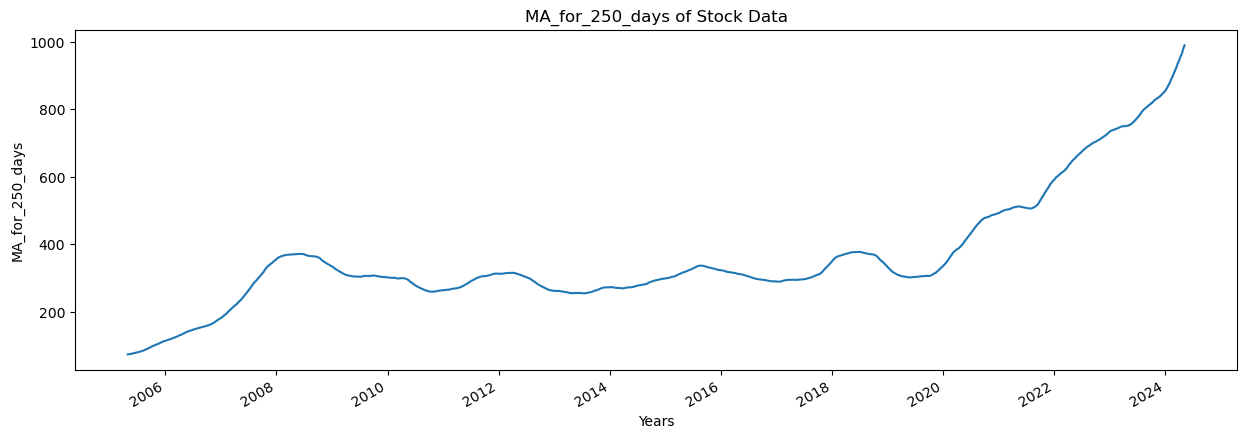

In [16]:
plot_graph((15,5), stock_data['MA_for_250_days'], 'MA_for_250_days')

<Figure size 640x480 with 0 Axes>

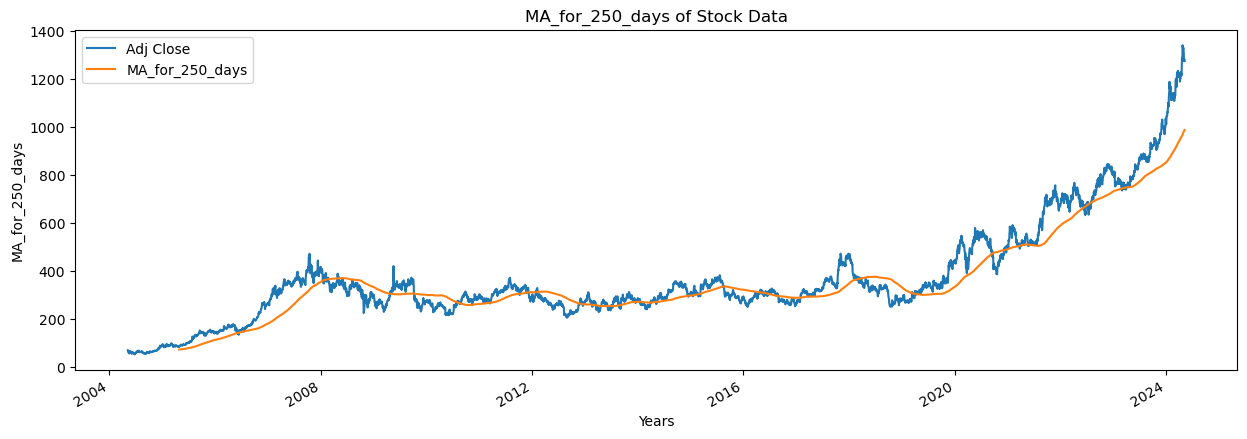

In [17]:
plot_graph((15,5), stock_data[['Adj Close','MA_for_250_days']], 'MA_for_250_days')

<Figure size 640x480 with 0 Axes>

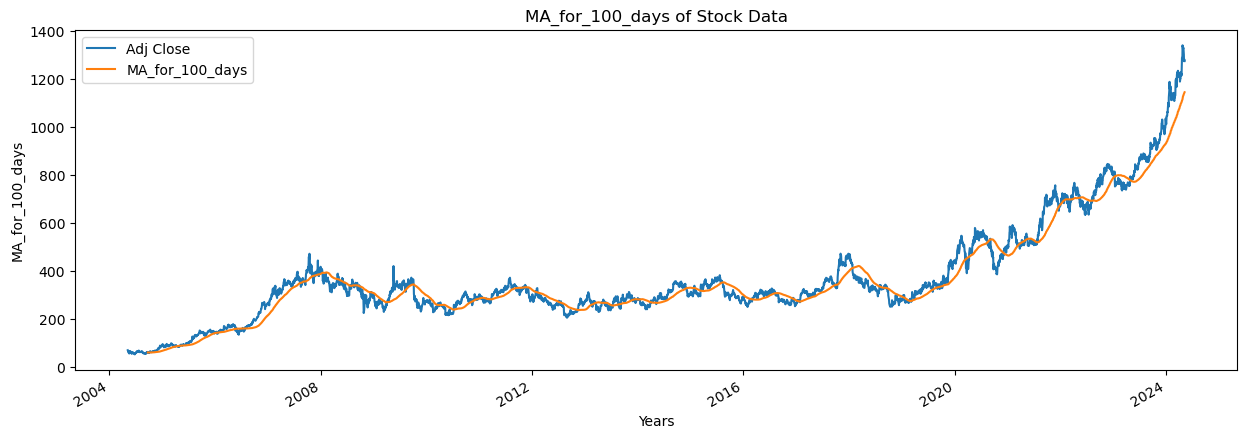

In [18]:
stock_data['MA_for_100_days'] = stock_data['Adj Close'].rolling(100).mean()
plot_graph((15,5), stock_data[['Adj Close','MA_for_100_days']], 'MA_for_100_days')

In [19]:
plot_graph((15,5), stock_data[['Adj Close','MA_for_100_days', 'MA_for_250_days']], 'MA')

<Figure size 640x480 with 0 Axes>

In [20]:
stock_data['percentage_change_cp'] = stock_data['Adj Close'].pct_change()
stock_data[['Adj Close','percentage_change_cp']].head()

Adj Close  percentage_change_cp
Date                                       
2004-05-07  70.394676                   NaN
2004-05-10  66.362526             -0.057279
2004-05-11  63.359394             -0.045253
2004-05-12  64.451462              0.017236
2004-05-13  67.181557              0.042359

In [21]:
plot_graph((15,5), stock_data['percentage_change_cp'], 'percentage_change')

In [22]:
Adj_close_price = stock_data[['Adj Close']]
max(Adj_close_price.values),min(Adj_close_price.values)

(array([1342.34997559]), array([52.98501968]))

In [23]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(Adj_close_price)
scaled_data

array([[0.0135025 ],
       [0.01037527],
       [0.00804611],
       ...,
       [0.9496264 ],
       [0.95427986],
       [0.94885083]])

In [24]:
len(scaled_data)

4942

In [25]:
x_data = []
y_data = []

for i in range(100, len(scaled_data)):
    x_data.append(scaled_data[i-100:i])
    y_data.append(scaled_data[i])
    
x_data, y_data = np.array(x_data), np.array(y_data)

In [26]:
x_data[0],y_data[0]

(array([[0.0135025 ],
        [0.01037527],
        [0.00804611],
        [0.00889309],
        [0.01101049],
        [0.00496774],
        [0.00289921],
        [0.00654766],
        [0.00933285],
        [0.00785067],
        [0.00710144],
        [0.00921884],
        [0.00791582],
        [0.00951202],
        [0.00895823],
        [0.00713402],
        [0.00400677],
        [0.00400677],
        [0.00487002],
        [0.0037136 ],
        [0.00213369],
        [0.00467457],
        [0.0066128 ],
        [0.00759007],
        [0.00772038],
        [0.00516321],
        [0.00407193],
        [0.00366473],
        [0.00324125],
        [0.00298065],
        [0.00307837],
        [0.00149846],
        [0.00206854],
        [0.00136816],
        [0.        ],
        [0.00244315],
        [0.00353443],
        [0.00376246],
        [0.00338785],
        [0.00431624],
        [0.0057007 ],
        [0.00700371],
        [0.00757378],
        [0.00630334],
        [0.00732947],
        [0

In [27]:
int(len(x_data)*0.7)

3389

In [28]:
len(scaled_data)-100-int(len(x_data)*0.7)

1453

In [29]:
splitting_len = int(len(x_data)*0.7)
x_train = x_data[:splitting_len]
y_train = y_data[:splitting_len]

x_test = x_data[splitting_len:]
y_test = y_data[splitting_len:]

In [30]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3389, 100, 1)
(3389, 1)
(1453, 100, 1)
(1453, 1)


In [31]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\divit\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
model.fit(x_train, y_train, batch_size=32, epochs = 2)

Epoch 1/2
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - loss: 0.0037
Epoch 2/2
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - loss: 1.0581e-04


In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,859 (1.35 MB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,240 (918.91 KB)

In [34]:
predictions = model.predict(x_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step


In [35]:
predictions

array([[0.21619065],
       [0.21646237],
       [0.2166606 ],
       ...,
       [0.9222263 ],
       [0.92358255],
       [0.9234809 ]], dtype=float32)

In [36]:
inv_predictions = scaler.inverse_transform(predictions)
inv_predictions

array([[ 331.73367],
       [ 332.084  ],
       [ 332.33963],
       ...,
       [1242.0713 ],
       [1243.82   ],
       [1243.689  ]], dtype=float32)

In [37]:
inv_y_test = scaler.inverse_transform(y_test)
inv_y_test

array([[ 330.14001465],
       [ 331.67449951],
       [ 325.22949219],
       ...,
       [1277.40002441],
       [1283.40002441],
       [1276.40002441]])

In [38]:
rmse = np.sqrt(np.mean( (inv_predictions - inv_y_test)**2))
rmse

28.673030726616346

In [39]:
ploting_data = pd.DataFrame(
 {
  'original_test_data': inv_y_test.reshape(-1),
    'predictions': inv_predictions.reshape(-1)
 } ,
    index = stock_data.index[splitting_len+100:]
)
ploting_data.head()

original_test_data  predictions
Date                                       
2018-06-14          330.140015   331.733673
2018-06-15          331.674500   332.084015
2018-06-18          325.229492   332.339630
2018-06-19          325.492615   332.192505
2018-06-20          326.106384   331.790466

<Figure size 640x480 with 0 Axes>

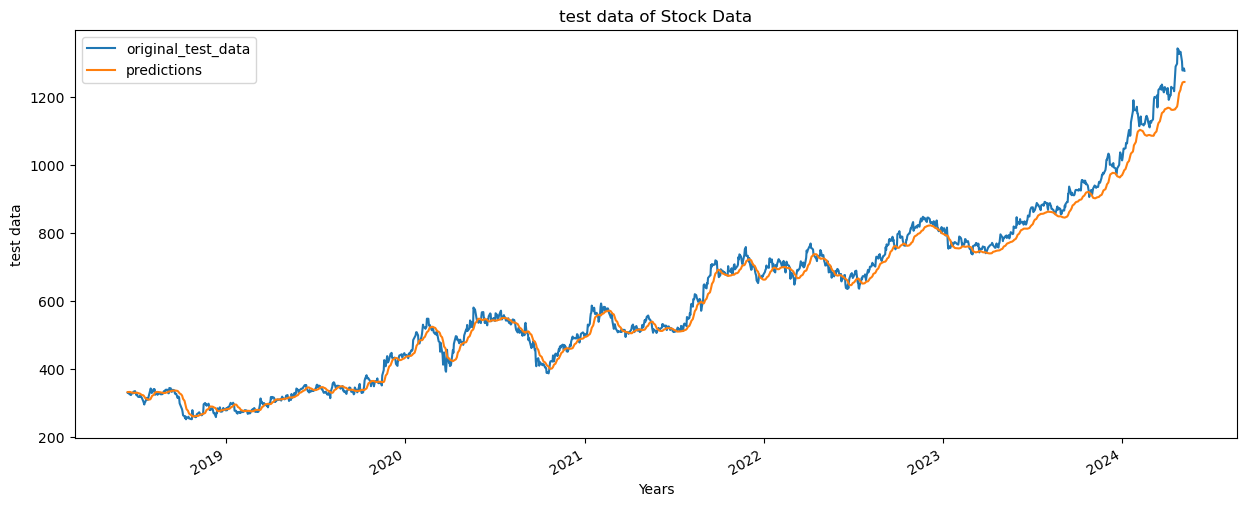

In [40]:
plot_graph((15,6), ploting_data, 'test data')

<Figure size 640x480 with 0 Axes>

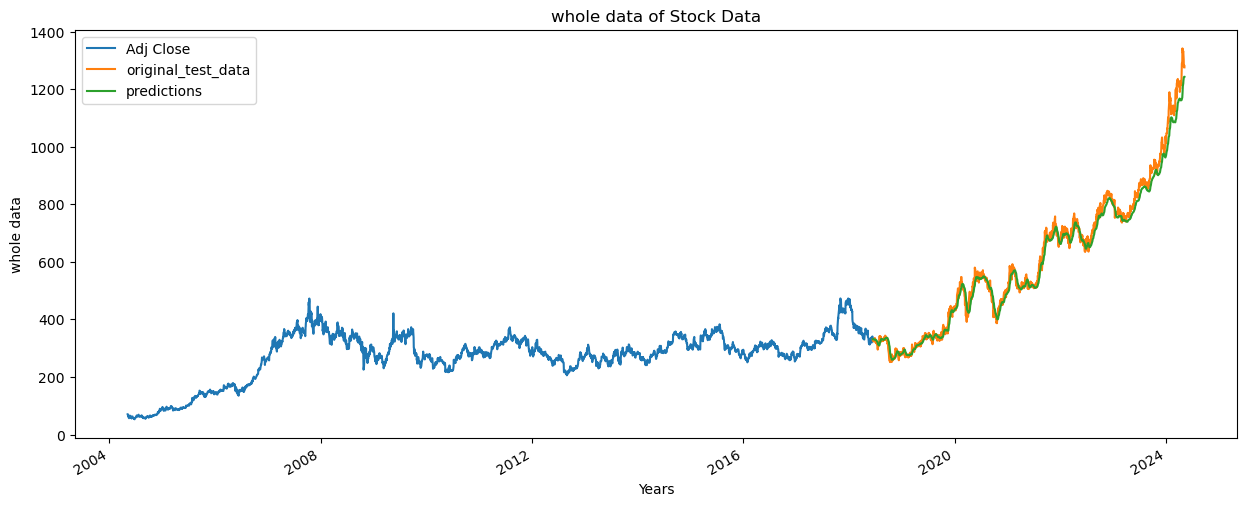

In [41]:
plot_graph((15,6), pd.concat([Adj_close_price[:splitting_len+100],ploting_data], axis=0), 'whole data')

In [42]:
model.save("Latest_stock_price_model.keras")